In [6]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [7]:
def N15_testing():
    """ Test function to implement the estimator for the N15 fit with offset. """
    x_axis = np.linspace(2850, 2860, 101)*1e6

    mod,params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)
#            print('Parameters of the model',mod.param_names)

    p = Parameters()

    p.add('l0_amplitude',value=-1e4)
    p.add('l0_center',value=2850*1e6+abs(np.random.random(1)*8)*1e6)
#            p.add('lorentz0_sigma',value=abs(np.random.random(1)*1)*1e6+0.5*1e6)
    p.add('l0_sigma',value=0.5*1e6)
    p.add('l1_amplitude',value=p['l0_amplitude'].value)
    p.add('l1_center',value=p['l0_center'].value+3.03*1e6)
    p.add('l1_sigma',value=p['l0_sigma'].value)
    p.add('offset',value=100000.)

    data_nice = mod.eval(x=x_axis, params=p)

    data_noisy= data_nice + 6000*np.random.normal(size=x_axis.shape)

    data_smooth_lorentz, offset = fitlogic.find_offset_parameter(x_axis, data_noisy)

    print('offset:', offset)

    x_offset = np.array([offset]*len(x_axis))

    plt.figure()
    plt.plot(x_axis, data_noisy, label='noisy data')
    plt.plot(x_axis, data_smooth_lorentz, label='smoothed data')
    plt.plot(x_axis, x_offset, label='offset estimation')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    hf_splitting = 3.03 * 1e6 # Hz

    # filter should always have a length of approx linewidth 1MHz
    points_within_1MHz = len(x_axis) / (x_axis.max() - x_axis.min()) * 1e6

    # filter should have a width of 4 MHz
    x_filter = np.linspace(0, 4 * points_within_1MHz, 4 * points_within_1MHz)
    lorentz = np.piecewise(
        x_filter,
        [(x_filter >= 0)*(x_filter < len(x_filter)/4),
            (x_filter >= len(x_filter)/4)*(x_filter < len(x_filter)*3/4),
            (x_filter >= len(x_filter)*3/4)],
        [1, 0, 1])

    # if the filter is smaller than 3 points a convolution does not make sense
    if len(lorentz) >= 3:
        data_convolved = filters.convolve1d(
            data_smooth_lorentz,
            lorentz / lorentz.sum(),
            mode='constant',
            cval=data_smooth_lorentz.max())
        x_axis_min = x_axis[data_convolved.argmin()]-hf_splitting/2.
    else:
        x_axis_min = x_axis[data_smooth_lorentz.argmin()]

    # data_level = data_smooth_lorentz - data_smooth_lorentz.max()
    data_level = data_smooth_lorentz - offset

    # multiply
    minimum_level = data_level.min()

    x_min_level = np.array([minimum_level] * len(x_axis))

    plt.figure()
    plt.plot(x_axis, data_noisy-offset, label='leveled noisy data')
    plt.plot(x_axis, data_level, label='leveled smoothed data')
    plt.plot(x_axis, x_min_level, label='minimum level estimation')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # integral of data:
    function = InterpolatedUnivariateSpline(x_axis, data_level, k=1)
    Integral = function.integral(x_axis[0], x_axis[-1])

    # assume both peaks contribute to the linewidth, so devive by 2:
    sigma = abs(Integral /(np.pi * minimum_level) )/2

    # amplitude = -1*abs(minimum_level*np.pi*sigma)
    amplitude = -abs(minimum_level)

    minimal_sigma = x_axis[1]-x_axis[0]
    maximal_sigma = x_axis[-1]-x_axis[0]

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

    params['l0_amplitude'].set(value=amplitude, max=-1e-6)
    params['l0_center'].set(value=x_axis_min)
    params['l0_sigma'].set(value=sigma, min=minimal_sigma,
                                 max=maximal_sigma)
    params['l1_amplitude'].set(value=params['l0_amplitude'].value,
                               max=-1e-6)
    params['l1_center'].set(value=params['l0_center'].value+hf_splitting,
                            expr='l0_center+3.03*1e6')
    params['l1_sigma'].set(value=params['l0_sigma'].value,
                           min=minimal_sigma, max=maximal_sigma,
                           expr='l0_sigma')
    params['offset'].set(value=offset)

    result = mod.fit(data_noisy, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, data_noisy, label='original data')
    plt.plot(x_axis, result.init_fit,'-y', label='initial values')
    plt.plot(x_axis, result.best_fit,'-r', label='actual fit')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

offset: 97333.3408742


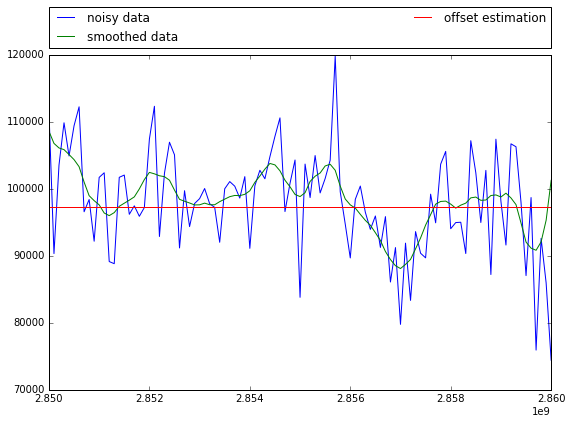

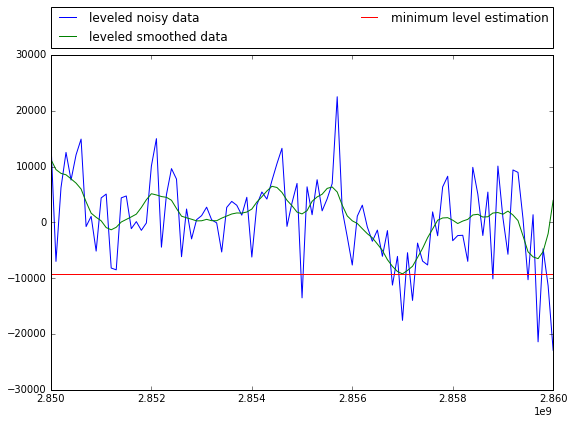

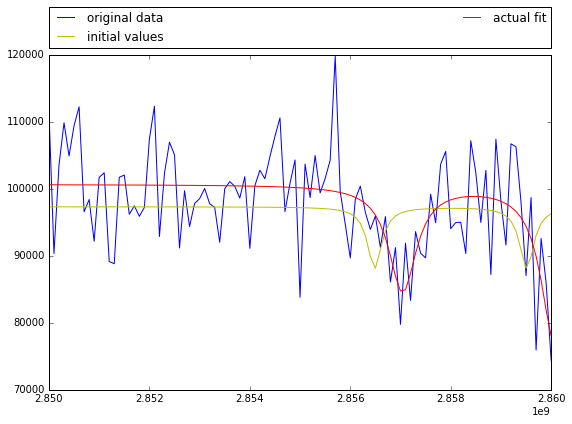

In [8]:
N15_testing()

In [9]:
def N15_testing2():
    """ Test direkt the implemented fit method with simulated data."""

    x_axis = np.linspace(2850, 2860, 101)*1e6

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)
#            print('Parameters of the model',mod.param_names)

    p = Parameters()

    p.add('l0_amplitude', value=-3e4)
    p.add('l0_center', value=2850*1e6+abs(np.random.random(1)*8)*1e6)
#            p.add('lorentz0_sigma',value=abs(np.random.random(1)*1)*1e6+0.5*1e6)
    p.add('l0_sigma', value=0.5*1e6)
    p.add('l1_amplitude', value=p['l0_amplitude'].value)
    p.add('l1_center', value=p['l0_center'].value+3.03*1e6)
    p.add('l1_sigma', value=p['l0_sigma'].value)
    p.add('offset', value=100.)

    data_nice = mod.eval(x=x_axis, params=p)

    data_noisy = (data_nice + 14000 * np.random.normal(size=x_axis.shape))

    result = fitlogic.make_lorentziandouble_fit(x_axis, data_noisy, estimator=fitlogic.estimate_lorentziandouble_N15)

    #plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis, result.init_fit,'-y', label='initial values')
    plt.plot(x_axis, result.best_fit,'-r', label='actual fit')
    plt.plot(x_axis, data_nice,'-g', label='actual fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

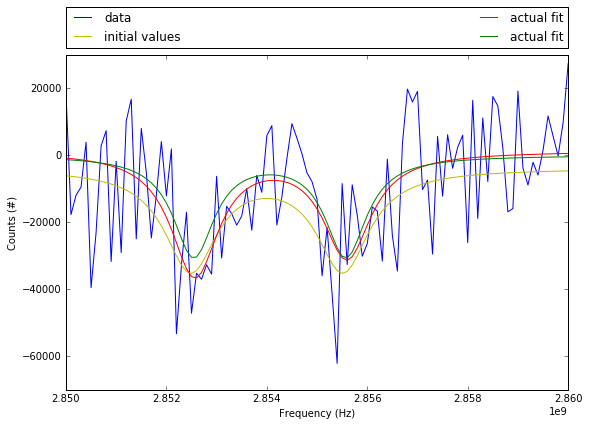

In [10]:
N15_testing2()